In [3]:

from pytorch_widedeep.preprocessing import TabPreprocessor, WidePreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.training import Trainer

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split




In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Dispositivo atual: {device}')

Dispositivo atual: cuda


In [5]:
train_csv = pd.read_csv('playground_data/train_balanced.csv')

In [6]:
train_csv = train_csv.drop(['Unnamed: 0','Unnamed: 0.1','classification'],axis=1)

In [7]:
train_csv.head(5)

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,0,0.35
2,rural,1,0.58,60,daylight,foggy,False,False,1,0.56
3,highway,3,0.54,70,night,foggy,True,False,0,0.61
4,highway,1,0.04,45,night,foggy,False,True,2,0.20


In [8]:
train_csv = pd.read_csv('playground_data/train_balanced.csv')
train_csv = train_csv.drop(['Unnamed: 0','Unnamed: 0.1','classification'],axis=1)
train_csv = train_csv.sample(frac=



#print(train_csv.head(5))

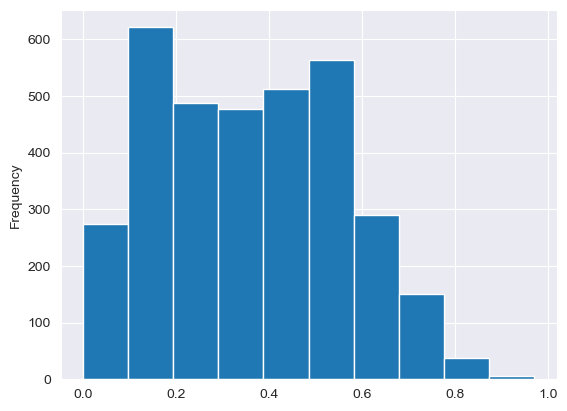

In [9]:
_ = train_csv['accident_risk'].plot(kind='hist')
plt.show()

In [20]:
# Tabular
tab_preprocessor = TabPreprocessor(
    embed_cols=['road_type','lighting','weather','road_signs_present','public_road'],
    continuous_cols=['num_lanes','curvature','num_reported_accidents','speed_limit'],
    cols_to_scale= ['num_lanes','curvature','num_reported_accidents','speed_limit']
    # scale = True
)


In [21]:
X = train_csv[['road_type','num_lanes','curvature','speed_limit','lighting','weather','road_signs_present','public_road','num_reported_accidents']]
y = train_csv['accident_risk']
#reduced train-test for quicker testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
#reduced train-test for quicker testing
X_train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,num_reported_accidents
155486,urban,1,0.97,60,daylight,foggy,False,True,1
92095,highway,1,0.32,70,daylight,clear,False,True,0
12044,rural,2,0.63,70,dim,foggy,False,True,2
338151,highway,1,0.26,45,daylight,rainy,True,False,0
187440,urban,1,0.70,60,dim,clear,True,False,0


In [22]:
X_tab_train = tab_preprocessor.fit_transform(X_train)
X_tab_test = tab_preprocessor.transform(X_test)

In [23]:

tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=tab_preprocessor.continuous_cols,
    mlp_hidden_dims=[32],
    #cont_norm_layer = 'layernorm',
    cont_embed_activation = 'leaky_relu',
)

In [24]:
# train_tensor = torch.utils.data.TensorDataset(torch.tensor(X_tab, dtype=torch.float32),
#                                               torch.tensor(train_csv["accident_risk"].values, dtype=torch.float32)
#                                               )
#
# train_loader = DataLoader(train_tensor, batch_size=32
#                           , shuffle=True
#                           )


In [25]:
model_mlp = WideDeep(deeptabular=tab_mlp)

In [26]:
torch.tensor(y_train.to_numpy())

tensor([0.6300, 0.2000, 0.4400,  ..., 0.4700, 0.0800, 0.4700],
       dtype=torch.float64)

In [29]:
trainer = Trainer(model_mlp, objective="regression",device = "cuda")

trainer.fit(
    X_tab=X_tab_train,
    target=torch.tensor(y_train.to_numpy()),
    n_epochs=3,
    batch_size=32
)

epoch 3: 100%|██████████| 86/86 [01:40<00:00,  1.17s/it, loss=0.00935] 


predict: 100%|██████████| 22/22 [00:15<00:00,  1.39it/s]


Mean Absolute Error: 0.05883168386742037
Mean Squared Error: 0.005563202947425425
Root Mean Squared Error: 0.07458688187225301
R^2 Score: 0.8491295047868854


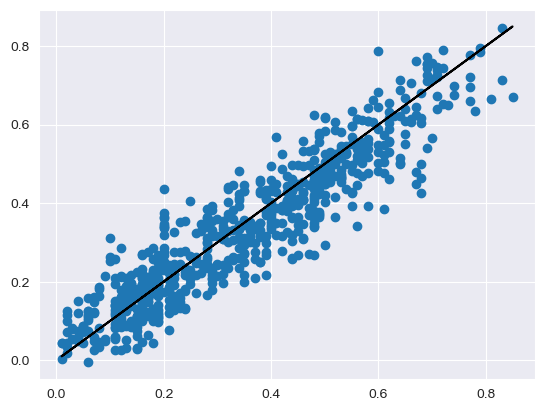

In [30]:
trues = y_test
preds = trainer.predict(X_tab=X_tab_test)
mae = mean_absolute_error(trues, preds)
mse = mean_squared_error(trues, preds)
rmse = np.sqrt(mse)
r2 = r2_score(trues, preds)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

plt.scatter(trues, preds)
plt.plot(trues, trues, 'k')
plt.show()

In [31]:
print(model_mlp)

WideDeep(
  (deeptabular): Sequential(
    (0): TabMlp(
      (cat_embed): DiffSizeCatEmbeddings(
        (embed_layers): ModuleDict(
          (emb_layer_road_type): Embedding(4, 3, padding_idx=0)
          (emb_layer_lighting): Embedding(4, 3, padding_idx=0)
          (emb_layer_weather): Embedding(4, 3, padding_idx=0)
          (emb_layer_road_signs_present): Embedding(3, 2, padding_idx=0)
          (emb_layer_public_road): Embedding(3, 2, padding_idx=0)
        )
        (embedding_dropout): Dropout(p=0.0, inplace=False)
      )
      (cont_norm): Identity()
      (encoder): MLP(
        (mlp): Sequential(
          (dense_layer_0): Sequential(
            (0): Linear(in_features=17, out_features=32, bias=True)
            (1): ReLU(inplace=True)
            (2): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
)
